In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip '/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/ml-1m.zip'

Archive:  /content/drive/My Drive/Gohlke_ExplainableRecommendation/files/ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
import pandas as pd
import numpy as np
import time
import math
from matplotlib import pyplot as plt 
from scipy import sparse
import pickle
import tensorflow.compat.v1 as tf
from sklearn.model_selection import train_test_split
import os
import random
from matplotlib import pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import ndcg_score

tf.disable_v2_behavior()

# !nvidia-smi
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

Instructions for updating:
non-resource variables are not supported in the long term


Helper Functions

In [4]:
def sigmoid(X):
   return 1/(1+np.exp(-X))

In [7]:
class BPR():
    def __init__(self,k,lr,batch_size,regularizer, model_name="model",seed=12345, recomAmount = 10):
        
        print("Initializing BPR instance")
        self.batch_size = batch_size
        self.lr = lr

        #features per user
        self.k = k
        [self.lamda_W,self.lambda_Hi,self.lambda_Hj] = regularizer
        self.model_name = model_name
        self.seed=seed
        
        self.data, self.users,self.movies = self.load_data()
        self.recomAmount = recomAmount
        # print("Data loaded")
        # print(len(self.data))
        # print(len(self.users))
        # print(len(self.movies))
        self.S_train, self.S_test = self.create_splits()

        self.model_graph = tf.Graph()
        self.build_graph()
        self.session = tf.Session(graph=self.model_graph)
        self.session.run(self.init)
           
    def load_data(self, force = False):
        if(not force and os.path.exists('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/df.pickle') 
          and os.path.exists('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/users.pickle')
          and os.path.exists('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/movies.pickle')):
          print("loading data")
          with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/df.pickle', 'rb') as handle:
                df = pickle.load(handle)
          with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/users.pickle', 'rb') as handle:
                users = pickle.load(handle)
          with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/movies.pickle', 'rb') as handle:
                movies = pickle.load(handle)
        else:
          print("loading/preprocessing data")
          df = pd.read_csv(os.path.join('ml-1m', 'ratings.dat'), 
                  sep=r':{2,}', 
                  usecols=[0,1,2,3], 
                  names=['userId', 'movieId', 'rating', 'timestamp'],
                  engine='python')

          movies = sorted(set(df['movieId']))
          movies = {c: i for (i, c) in enumerate(movies)}
          users = sorted(set(df["userId"]))
          users = {c: i for (i, c) in enumerate(users)}

          #preprocess
          df['userId'] = df['userId'].replace(users)
          df['movieId'] = df['movieId'].replace(movies)

          with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/df.pickle', 'wb') as handle:
                pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

          with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/users.pickle', 'wb') as handle:
                pickle.dump(users, handle, protocol=pickle.HIGHEST_PROTOCOL)

          with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/movies.pickle', 'wb') as handle:
                pickle.dump(movies, handle, protocol=pickle.HIGHEST_PROTOCOL)

        return df, users, movies

    def create_splits(self, force = False):
        if(not force and os.path.exists('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/S_train.pickle') 
            and os.path.exists('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/S_test.pickle')):
            print("loading splits")

            with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/S_train.pickle', 'rb') as handle:
                S_train = pickle.load(handle)
            with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/S_test.pickle', 'rb') as handle:
                S_test = pickle.load(handle)
        else:
            print("creating splits")
            train_df, test_df = train_test_split(self.data, train_size = 0.8, random_state = 42)

            S_train=sparse.csr_matrix((len(self.users), len(self.movies)), dtype=np.int8)
            S_test=sparse.csr_matrix((len(self.users), len(self.movies)), dtype=np.int8)

            for i in range(len(train_df)):
                S_train[train_df.iloc[i]["userId"], train_df.iloc[i]["movieId"]]=1

            for i in range(len(test_df)):
                S_test[test_df.iloc[i]["userId"], test_df.iloc[i]["movieId"]]=1

            with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/S_train.pickle', 'wb') as handle:
                pickle.dump(S_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

            with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/S_test.pickle', 'wb') as handle:
                pickle.dump(S_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

        return S_train,S_test

    def sampler(self,S,batch_size=1):
        counter=batch_size
        u,i,j = [],[],[]
      
        while(counter!=0):
          user=np.random.randint(0,S.shape[0])
          ones=list(S[user,:].nonzero()[1])
      
          if(len(ones)!=0):
            u.append(user)
            i.append(np.asscalar(np.random.choice(ones,1)))
         
            while(True):
                val=np.random.randint(0,len(self.movies))
                if val not in ones:
                    break
            j.append(val)  
            counter=counter-1
          
        return u,i,j
        
    def build_graph(self):
        tf.reset_default_graph() 
        with self.model_graph.as_default(): 
            self.uu = tf.placeholder(tf.int32, shape=[None])
            self.ii = tf.placeholder(tf.int32, shape=[None])
            self.jj = tf.placeholder(tf.int32, shape=[None])
            
            with tf.variable_scope("parameters", reuse=False):
                self.W=tf.get_variable("user_features",shape=(len(self.users),self.k),
                                initializer=tf.random_normal_initializer(0, 0.1,seed=self.seed),trainable=True)
                self.Hi=tf.get_variable("item_i",shape=(len(self.movies),self.k),
                                initializer=tf.random_normal_initializer(0, 0.1,seed=(self.seed+1)),trainable=True)
                self.Hj=tf.get_variable("item_j",shape=(len(self.movies),self.k),
                                initializer=tf.random_normal_initializer(0, 0.1,seed=(self.seed-1)),trainable=True)
                
            self.embed_u = tf.nn.embedding_lookup(self.W,self.uu,name="W")
            self.embed_i = tf.nn.embedding_lookup(self.Hi,self.ii,name="Hi")
            self.embed_j = tf.nn.embedding_lookup(self.Hj,self.jj,name="Hj")
            
            self.X_uij = tf.reduce_sum(tf.multiply(self.embed_u, (self.embed_i - self.embed_j)),1, keep_dims=True)

            self.prob=tf.sigmoid(self.X_uij)
            
            self.reg_W  =  tf.reduce_mean(self.embed_u*self.embed_u)
            self.reg_Hi =  tf.reduce_mean(self.embed_i*self.embed_i) 
            self.reg_Hj =  tf.reduce_mean(self.embed_j*self.embed_j)
                        
            self.loss = tf.reduce_mean(tf.log(self.prob))
            self.reg  = self.lamda_W*self.reg_W  +  self.lambda_Hi*self.reg_Hi + self.lambda_Hj*self.reg_Hj
            self.total_loss = -self.loss + self.reg
            
            self.optim=tf.train.GradientDescentOptimizer(learning_rate=self.lr)
            self.step = self.optim.minimize(self.total_loss)
            # self.step = self.optim.minimize(self.loss)

            self.saver = tf.train.Saver()
            self.init=tf.global_variables_initializer()

    def train(self, epochs):
        epochs_hist = []
        train_loss_hist = []
        eval_loss_hist = []
        hr_hist = [] 
        for i in range(epochs):
          epoch_loss = 0
          for j in range(int(self.S_train.shape[0]/self.batch_size)):
            a,b,c = self.sampler(self.S_train,self.batch_size)
            feed_dict = {self.uu:a , self.ii:b , self.jj:c}

            loss, _ = self.session.run((self.total_loss, self.step),feed_dict=feed_dict)
            epoch_loss = epoch_loss + loss
          
          if(i%1 == 0):
            a,b,c = self.sampler(self.S_test,self.S_test.shape[0])
            feed_dict = {self.uu:a , self.ii:b , self.jj:c }
            eval_loss = self.session.run((self.total_loss),feed_dict=feed_dict)
            hr,ndcg,ar = bpr.evaluateHR_NDCG(userAmount = 100)
            train_loss = epoch_loss/int(self.S_train.shape[0]/self.batch_size)

            epochs_hist.append(i)
            train_loss_hist.append(train_loss)
            eval_loss_hist.append(eval_loss)
            hr_hist.append(hr)

            print("Epoch:{} Train_Loss:{} Test_Loss:{} NDCG: {}, HR:{}, AR:{}".format(i,train_loss, eval_loss, ndcg, hr, ar))

        self.epochs_hist = epochs_hist
        self.train_loss_hist = train_loss_hist
        self.eval_loss_hist = eval_loss_hist
        self.hr_hist = hr_hist
    
    def save(self,model_name = None, suffix=0):
         if model_name == None:
           model_name = self.model_name
          
         save_path = self.saver.save(self.session, "/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/models/{}-{}/".format(model_name, suffix))
         print("Model saved in path: %s" % save_path)
     
    def evaluate(self,user,i,j):
         prob=self.session.run(self.prob, feed_dict={self.uu:[user] ,self.ii:[i] ,self.jj:[j]})
        #  print("The probability that the user {} prefers item {} over item {} is {}".format(user,i,j,np.asscalar(prob)))
         return prob

    def load(self,model_name = None, suffix=0):
        if model_name == None:
           model_name = self.model_name

        saver = tf.train.import_meta_graph("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/models/{}-{}/.meta".format(model_name, suffix))
        saver.restore(self.session, "/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/models/{}-{}/".format(model_name, suffix))

    def close(self):
         tf.reset_default_graph()
         self.session.close()

    def recommend(self, u, recomAmount):
        #maximizing dot product of U and item i means maximizing probability that user U prefers i over j
        userVals = self.W[u, :].eval(session = self.session)
        iVals = self.Hi.eval(session = self.session).T
   
        scores = np.dot(userVals, iVals)
        args = scores.argsort()[::-1]

        recommendations = []
        
        i = 0
        while(len(recommendations) < self.recomAmount):
          if(self.S_train[u, args[i]] == 0): #if user didn't already rate the item
            recommendations.append(args[i])
          i = i+1
        return recommendations

    def evaluateHR_NDCG(self, userAmount = 6040):
        hit_count = 0
        total_count = 0
        attempt_count = 0
        ndcg = []

        users = random.sample(range(0,len(self.users)), userAmount)

        for user in users:
            top_predictions = self.recommend(user, recomAmount = 10)
            user_movies = self.S_test[user].nonzero()[1]

            y_pred = np.asarray([[0 for i in range(self.recomAmount)]])
            y_true = np.asarray([[1 for i in range(self.recomAmount)]])
              
            for i in range(self.recomAmount):
                if top_predictions[i] in user_movies:
                    y_pred[0][i] = 1
                    hit_count = hit_count+1
                attempt_count = attempt_count + 1

            total_count = total_count + len(user_movies)

            ndcg.append(ndcg_score(y_pred, y_true))
            
        return hit_count/total_count,  np.mean(ndcg) , hit_count/attempt_count
        # #hit_ratio = []
        # for user in range(min(len(self.users), max_users)):
        #     hit_count = 0
        #     top_predictions = self.recommend(user)

        #     user_movies = self.S_test[user].nonzero()[1]

        #     if(len(user_movies)>0):
        #       for movie in user_movies:
        #           if movie in top_predictions:
        #               hit_count = hit_count+1
        #       # print("hit {} among {} total".format(hit_count/len(user_movies), len(user_movies)))
        #       hit_ratio.append(hit_count/len(user_movies))

        # print("HR is ", np.mean(hit_ratio))
        # return np.mean(hit_ratio)

    def plot_history(self):
      plt.plot(self.epochs_hist, self.train_loss_hist, 'r--')
      plt.plot(self.epochs_hist, self.eval_loss_hist, 'b-')
      plt.legend(['Training Loss', 'Test Loss'])
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.savefig('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/plots/lr{}-k{}-reg{}-batchS{}-loss_history.png'.format(self.lr, self.k,self.lamda_W,self.batch_size))
      plt.show()
      plt.clf()

      plt.plot(self.epochs_hist, self.hr_hist, 'g--')
      plt.xlabel('Epoch')
      plt.ylabel('Hit Ration on Testing Set')
      plt.savefig('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/plots/lr{}-k{}-reg{}-batchS{}-hr_history.png'.format(self.lr, self.k,self.lamda_W,self.batch_size))
      plt.show()
      plt.clf()

bpr = BPR(k = 100, lr = 0.5, batch_size = 1, model_name = "main", regularizer=[0.00001, 0.00001, 0.00001])
# bpr.load(model_name = "main", suffix="0")

Initializing BPR instance
loading data
loading splits


In [8]:
lr = [0.05,0.1,0.5]
k = [1,5,10,20,100]

for i in range(len(lr)):
  for j in range(len(k)):
    bpr = BPR(k = k[j], lr = lr[i], batch_size = 1, model_name = "modelloweredReg", regularizer=[0.00001, 0.00001, 0.00001])
    epochs = 10
    bpr.train(epochs)
    # bpr.save(model_name = "modelloweredReg", suffix="lr{}-k{}".format(lr[i],k[j]))
    bpr.plot_history()

In [12]:
lr = [0.05,0.1,0.5]
k = [1,5,10,20,100]
max_users = 100

HR_scores = np.zeros((len(lr), len(k)))
NDCG_scores = np.zeros((len(lr), len(k)))

for i in range(len(lr)):
  for j in range(len(k)):
    bpr = BPR(k = k[j], lr = lr[i], batch_size = 1, model_name = "modelloweredReg", regularizer=[0.00001, 0.00001, 0.00001])
    bpr.load(model_name = "modelloweredReg", suffix="lr{}-k{}".format(lr[i],k[j]))
    hr, ndcg, ar = bpr.evaluateHR_NDCG(max_users)
    HR_scores[i][j] = hr
    NDCG_scores[i][j] = ndcg
    print("For lr {} and k {}, HR is: {}, NDCG:{} Hit/Attempt Ratio: {}".format(lr[i], k[j], hr, ndcg, ar))

    np.save("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/HR_scores.npy", HR_scores) #in case of crashing, saves temporarily
    np.save("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/NDCG_scores.npy", NDCG_scores) #in case of crashing, saves temporarily

Initializing BPR instance
loading data
loading splits
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/models/modelloweredReg-lr0.05-k1/
For lr 0.05 and k 1, HR is: 0.012269938650306749, NDCG:0.12621876742386035 Hit/Attempt Ratio: 0.038
Initializing BPR instance
loading data
loading splits
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/models/modelloweredReg-lr0.05-k5/
For lr 0.05 and k 5, HR is: 0.027080581241743725, NDCG:0.2522981454911627 Hit/Attempt Ratio: 0.082
Initializing BPR instance
loading data
loading splits
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/models/modelloweredReg-lr0.05-k10/
For lr 0.05 and k 10, HR is: 0.04503616042077581, NDCG:0.3287735180035955 Hit/Attempt Ratio: 0.137
Initializing BPR instance
loading data
loading splits
INFO:tensorflow:Restoring parameters from /content/drive

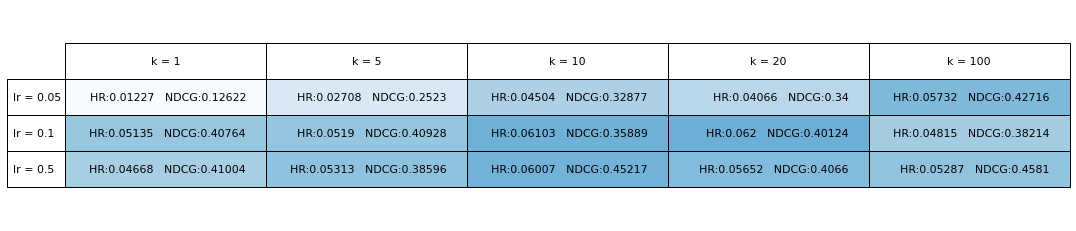

<Figure size 432x288 with 0 Axes>

In [14]:
# Prepare table
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

lr = [0.05,0.1,0.5]
k = [1,5,10,20, 100]

decimals = 5

HR_scores = np.load("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/HR_scores.npy")
NDCG_scores = np.load("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/NDCG_scores.npy")

cell_text = np.empty((len(lr),len(k))).astype(str)

minmax = MinMaxScaler()
hr_norm = minmax.fit_transform(HR_scores.reshape(-1,1))
hr_norm = hr_norm.reshape(HR_scores.shape)

minmax = MinMaxScaler()
ndcg_norm = minmax.fit_transform(NDCG_scores.reshape(-1,1))
ndcg_norm = hr_norm.reshape(NDCG_scores.shape)


colors = np.zeros((len(lr),len(k),3))

Blues = plt.get_cmap('Blues')
for i in range(len(lr)):
  for j in range(len(k)):
    cell_text[i][j] = str("HR:{}".format(np.round(HR_scores[i][j], decimals)) + "   NDCG:{}".format(np.round(NDCG_scores[i][j], decimals)))
    colors[i][j][0] = Blues((hr_norm[i][j] + ndcg_norm[i][j])/4)[0]
    colors[i][j][1] = Blues((hr_norm[i][j] + ndcg_norm[i][j])/4)[1]
    colors[i][j][2] = Blues((hr_norm[i][j] + ndcg_norm[i][j])/4)[2]

plt.axis('off')
table = plt.table(cellText=cell_text, rowLabels = ["lr = " + str(i) for i in lr], colLabels=["k = " + str(i) for i in k], loc='center',  fontsize=12, cellColours=colors)
table.set_fontsize(14)
table.scale(3, 3)
plt.show()
plt.savefig('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/scores.png')
plt.clf()